# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd

In [3]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [84]:
print(sum(data['nb_test']))

1257054


In [41]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

- `data.nb_pos[i]` : nombre de personnes testées positives sur l'échantillon i 
- `data.nb_test[i]`: nombre de personnes testées dans l'échantillon i 
- `data.prob[i]`: probabilité empirique d'être positif sur l'étude i
- `proba_constante`: probabilité empirique d'être positif. 

<AxesSubplot:xlabel='nb_test', ylabel='Count'>

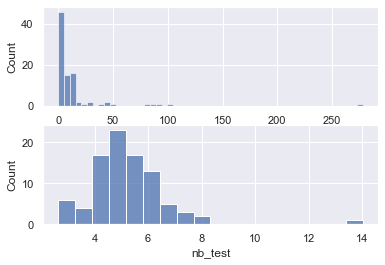

In [103]:
fig, ax = plt.subplots(2,1)
sns.histplot(data['nb_pos'], ax=ax[0])
sns.histplot(np.log(data['nb_test']), ax=ax[1])

# Question 1 : détermination de la loi a posteriori dans un cas simple

## Calculs théoriques 
On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante $p$.


Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$, de fonction de masse $f(r_i, p) = \binom{n_i}{r_i} p^{r_i} (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ donc de densité $\mathbb{1}_{[0,1]}(p)$

La densité de la loi a posteriori est alors ($n$=91 est le nombre d'études) : 

$\pi(p|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p) \mathbb{1}_{[0,1]}(p) 
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p^{r_i} (1-p)^{(n_i-r_i)}  
\\  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto p^{\sum_{i=1}^{n}r_i} (1-p)^{\sum_{i=1}^{n}(n_i-r_i)}  \sim \mathcal{B}eta(\sum_{i=1}^{n}r_i +1, \sum_{i=1}^{n}(n_i-r_i)+1)$

Les observations nous permettent alors de calculer les deux paramètres de cette loi Bêta :


In [105]:
print("premier paramètre =",sum(data['nb_pos'])+1)
print("deuxième paramètre =",sum(data['nb_test'])-sum(data['nb_pos'])+1)

premier paramètre = 1329
deuxième paramètre = 1255727


Finalement, la loi a posteriori de $p$ est une $\boxed{\mathcal{B}eta(1329,1255727)}$

## Génération de lois utiles

### Loi exponentielle 



In [106]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi Gamma 
Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 

------------
**Lemme.** 

  > Soient $X$ et $Y$ deux variables independantes distribuees suivant des lois  $\Gamma(a,1)$ et $\Gamma(b,1)$
    Alors $U = X+Y$ et $V = X/(X+Y)$ sont deux variables independantes distribuees suivant des lois $\Gamma(a+b,1)$ et $\mathcal{B}eta(a,b)$.





In [223]:
#def gamma(x):
#    """
#    Calcul de l'intégrale de Gamma de paramètre x par Monte Carlo
#    """
#    l = [gen_exp(x) for i in range(1000)]
#    return np.mean(l)
from math import gamma 

def f(x, a, b):
    """ 
    densité de la loi Gamma(a,b) en x 
    """
    return b**a*x**(a-1)*np.exp(-b*x)/gamma(a)


In [224]:
def gen_gamma(a,b):
    """ 
    Algorithme de génération d'une distribution Gamma(a,b)
    """
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if a == 1:
        return gen_exp(b)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif a == int(a) and a > 1 : 
        return sum([gen_exp(b) for i in range(a)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            x = gen_gamma(int(a), b+1)
            # constante calculée dans la photo sur messenger
            c = b**a/((b+1)**int(a))*gamma(int(a))/gamma(a)*(a-int(a))**(a-int(a))*np.exp(-int(a)+a)
            u = rd.random()
            # on va utiliser une loi de gamma de paramètres entiers pour g
            if u <= c*f(x, a, b)/f(x, int(a), b+1):
                return x 
        
        

In [225]:
def gen_beta(alpha, beta):
    """
    Algorithme de génération de loi Beta(alpha, beta) à partir du lemme 
    """
    X = gen_gamma(alpha, 1)
    Y = gen_gamma(beta,1)
    return X/(X+Y)

In [226]:
def gen_bernoulli(p):
    if rd.random() <= p :
        return 1
    return 0

In [227]:
def gen_binomiale(n,p):
    return sum([gen_bernoulli(p) for i in range(n)])


Représentation graphique 


Loi a posteriori : $\pi(p|r_1,\dots,r_n) \sim \mathcal{B}eta(\sum_i^n r_i+1, \sum_i^n n_i-r_i+1)$

In [115]:
#Rééchantillonnage inutile...
#list_n = data['nb_test'].tolist()
#r_list = []
#for elem in list_n:
#    r_list.append(gen_binomiale(elem,pb)) 
#R = sum(r_list)+1
#N = sum(list_n)-sum(r_list)+1 
#R,N

(1266, 1255790)

----- En fait c'est inutile de relancer les Bernoullis, c'est la loi *a posteriori* donc on prend juste les données et on génère la loi Beta avec les paramètres calculés -----

       En rééchantillonnant les `nb_pos`ie $r_i$, on génère une a posteriori $\mathcal{B}eta(1266, 1255790)$. 
    

On génère $\mathcal{B}eta(1329,1255727)$ déduite de l'étude. 

In [229]:
d_etude = [gen_beta(1329, 1255727) for i in range(100)]

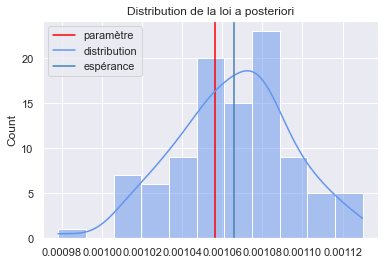

In [230]:
sns.set(style="darkgrid")
#sns.histplot(distr, kde=True, col="blue", label='reechantillonnage', alpha=0.7)
plt.axvline(proba_constante, color='red', label='paramètre')
sns.histplot(d_etude, kde = True, color='cornflowerblue', label='etudes')
p_esp = sum(d_etude)/len(d_etude)
plt.axvline(p_esp, color="steelblue", label='espérance de la distribution')
plt.title("Distribution de la loi a posteriori")
plt.legend(['paramètre', 'distribution', 'espérance'])

Le modèle n'approche pas très bien la probabilité agrégée de la présence de listeria (c'est-à-dire celle prise en agrégant l'ensemble des études).
Comme le montre le graphique ci-dessous, les études affichent des probabilités empiriques de présence de listeria assez variées. Il paraît donc plus judicieux de considérer des probabilités de présence de listeria $p_i$ qui varient avec l'étude $i$.$\newline$C'est l'objet de la deuxième question.

Text(0.5, 1.0, 'Distribution des probas a priori empiriques')

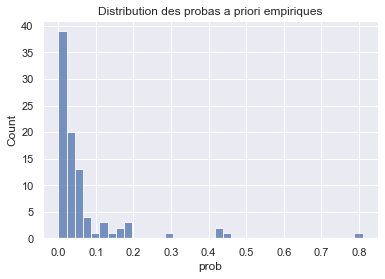

In [78]:
sns.histplot(data['prob'])
plt.title("Distribution des probas a priori empiriques")

# Question 2 : loi a posteriori avec reparamétrisation

## Calculs théoriques

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$, de fonction de masse $f(r_i, p_i) = \binom{n_i}{r_i} p_i^{r_i} (1-p_i)^{n_i-r_i}$

Loi a priori : $ \forall i, p_i \sim \mathcal{B}eta(\alpha,\beta)$, de densité $\displaystyle{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}}p_i^{\alpha-1}(1-p_i)^{\beta-1}\mathbb{1}_{[0,1]}(p_i)$

L'énoncé propose la reparamétrisation suivante : $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$

On supposera que : $\textbf{$\kappa$ et $\mu$ sont indépendantes}$ 

Donc on aura la densité jointe de $(\mu,\kappa)$ suivante : $p(\mu,\kappa)$ = $0.1 e^{-0.1\kappa}\mathbb{1}_{[0,1]}(\kappa)$
     
En inversant : $\alpha = \kappa \mu $ et $\beta = \kappa (1-\mu)$

Et donc $p_i$ a pour densité (sachant $\mu$ et $\kappa$) : $p(p_i|\mu,\kappa)$  = $\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}\mathbb{1}_{[0,1]}(p_i)$

La densité de la loi a posteriori est alors : 

$\pi(\mu,\kappa,p_1,...,p_n|r_1,\dots, r_n) \propto \prod_{i=1}^{n}f(r_i,p_i)p(p_i|\mu,\kappa)p(\mu,\kappa)
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \prod_{i=1}^{n} p_i^{r_i} (1-p_i)^{(n_i-r_i)}\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}p_i^{\kappa \mu-1}(1-p_i)^{\kappa(1-\mu)-1}e^{-0.1\kappa}  
\\    \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto e^{-0.1n\kappa}\left(\displaystyle{\frac{\Gamma(\kappa)}{\Gamma(\kappa \mu)\Gamma(\kappa (1-\mu))}}\right)^n\prod_{i=1}^{n} p_i^{r_i+\kappa \mu -1} (1-p_i)^{(n_i-r_i)+\kappa(1-\mu)-1}$ 

Contrairement au cas précédent, la loi a posteriori ne correspond pas à une loi usuelle connue. 
On va alors mettre en oeuvre un algorithme de $\textbf{Metropolis within Gibbs}$ pour simuler cette loi a posteriori, en s'appuyant sur les différentes lois (connues) de nos paramètres $(p_i)_i,\kappa$ et $\mu$.

Pour mettre en oeuvre l'algorithme de Gibbs-sampling, il nous faut simuler les lois marginales suivantes. 

On note $r = (r_1, \dots, r_n)$, $p = (p_1, \dots, p_n)$ et $\forall k \in \{1,\dots, n\}, \ p_{-k} = (p_1, \dots, p_{k-1}, p_{k+1}, \dots, p_n)$. 

On s'appuie sur les lois marginales proportionnelles à la loi a posteriori $\pi$ : 
- $\forall k, \ \pi(p_k | \mu, \kappa, r, p_{-k})  \propto \pi(\mu,\kappa, p|r) \\ \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto p_k^{r_k + \kappa \mu - 1} (1-p_k)^{n_k - r_k + \kappa(1-\mu) - 1} \\
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \sim \mathcal{B}eta(n_k-1+\kappa, r_k + \kappa\mu)$

- $\pi(\kappa| \mu, r, p)  \propto \pi(\mu,\kappa, p|r) \\ \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \frac{e^{-0.1 \kappa} \Gamma(\kappa)}{\Gamma(\kappa\mu) \Gamma((1-\mu)\kappa)} (\prod_i p_i)^{\kappa\mu -1} ( \prod_i (1-p_i))^{\kappa(1-\mu) -1} $
Loi non connue : on va utiliser un algorithme de Metropolis-Hastings pour la simuler. A priori cette loi n'est **pas indépendante** de $(\mu, r, p)$ donc on utilisera un MH random walk. 

- $\pi(\mu| \kappa, r, p)  \propto \pi(\mu,\kappa, p|r) \\ \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\,\,  \propto \frac{\Gamma(\kappa)}{\Gamma(\kappa\mu) \Gamma((1-\mu)\kappa)} (\prod_i (\frac{ p_i}{1-p_i})^{\kappa})^{\mu}  \mathbb{1}_{[0,1]}(\mu) $
Loi également non connue : on va utiliser à nouveau un algorithme de MH. A priori cette loi n'est **pas indépendante** de $(\mu, r, p)$ donc on utilisera un MH random walk. 

## Génération de la loi conditionnelle des $p_i$ 
Les $p_k \sim \mathcal{B}eta(n_k-1+\kappa, r_k+\kappa \mu)$. On va supposer que l'on génère $\kappa$ et $\mu$ via une chaîne de Markov avec les états précédents. 

In [233]:
def gen_cond_p(n,kappa, r, mu):
    """ 
    Prend en entrée n, r entiers, kappa et mu paramètres 
    """
    return gen_beta(n-1+kappa, r+kappa*mu)

## Génération de la loi marginale associée à $\mu$


In [234]:
def cond_loi_mu(kappa, mu, p):
    """
    Retourne la densité de la loi conditionnelle associée à mu :
        prend en entrée les paramètres kappa, mu et le vecteur p associée aux observations p_i 
    """
    prod=1
    for i in range(len(p)):
        prod*= (p[i]/(1-p[i]))**kappa
    return 1/(gamma(kappa*mu)*gamma(kappa*(1-mu))) * prod**mu
    

def log_pi(x, mu): 
    # loi de proposition : loi normale centrée en mu 
    return -0.5 * (x-mu)**2

def metropolis_mu(x, sig,mu, kappa): 
    """ Algorithme de Metropolis Hastings pour une marche aléatoire avec moyenne mu
    """
    y = x + sig * np.random.randn()  # random walk proposal 
    r = min(1, cond_loi_mu(kappa, mu, y)/cond_loi_mu(kappa, mu, x))
    if np.random.rand() < r:  # if u < r
        return y, r
    else:
        return x, r

## Génération de la loi conditionnelle $\kappa$

On utilise la même procédure que pour $\mu$ mais en remplaçant la loi conditionnelle liée au seuil de rejet. 

In [235]:
def cond_loi_kappa(kappa, mu, p):
    """
    Retourne la densité de la loi conditionnelle associée à kappa :
        prend en entrée les paramètres kappa, mu et le vecteur p associée aux observations p_i 
    """
    prod1=1
    prod2=1
    c = gamma(kappa)*np.exp(-0.1*kappa)/(gamma(kappa*mu)*gamma(kappa*(1-mu))) 
    for i in range(len(p)):
        prod1 *= p[i]**(kappa*mu -1)
        prod2 *= (1-p[i])**((1-mu)*kappa -1)
    return c*prod1*prod2


def metropolis_kappa(x, sig,mu, kappa): 
    """ Algorithme de Metropolis Hastings pour une marche aléatoire avec moyenne mu
    """
    y = x + sig * np.random.randn()  # random walk proposal 
    r = min(1,cond_loi_kappa(kappa, mu, y)/cond_loi_kappa(kappa, mu, x))
    if np.random.rand() < r : # if u < r
        return y, r
    else:
        return x, r

## Chaine de Markov Monte Carlo : 

Il nous reste à "construire" la chaîne de Markov. 

Il faut à présent "calibrer" $\sigma^2$ pour les deux algorithmes de Metropolis. 

### Metropolis pour $\mu$

In [239]:
df = pd.DataFrame()
rate, sigma = [],[]
n_sample =100
for j in range(1,10):#np.linspace(5,6,10):
    p = np.empty((n_sample, len(data['prob'])))
    r = np.empty(n_sample)
    p[0]=data['prob']
    mu = rd.random()
    kappa = gen_exp(0.1)
    for n in range(1,n_sample):
        p[n], r[n] =metropolis_mu(p[n-1], j, mu, kappa)
        #print(p[n], r[n])
    rate.append(np.mean(r)),sigma.append(j)
df['sigma**2']= sigma
df['rate']= rate

<ipython-input-234-f86e9dc2288d>:8: RuntimeWarning: invalid value encountered in double_scalars
  prod*= (p[i]/(1-p[i]))**kappa
<ipython-input-234-f86e9dc2288d>:8: RuntimeWarning: overflow encountered in double_scalars
  prod*= (p[i]/(1-p[i]))**kappa


In [240]:
df

,sigma**2,rate
0,1,0.990000
1,2,0.990011
2,3,0.990000
3,4,0.990011
4,5,0.990000
5,6,0.990011
6,7,0.990000
7,8,0.990011
8,9,0.990000


On choisit `sig = 5.11` pour avoir un ration d'acceptance de 0.44. 

In [208]:
p = np.empty(1000)
r = np.empty(1000)
p[0]=data['prob'][0]
mu = rd.random()
kappa = gen_exp(0.1)
for n in range(1,1000):
    p[n], r[n] =metropolis(p[n-1], sig=5.11)

Text(0.5, 1.0, 'MCMC avec sigma = 5.33')

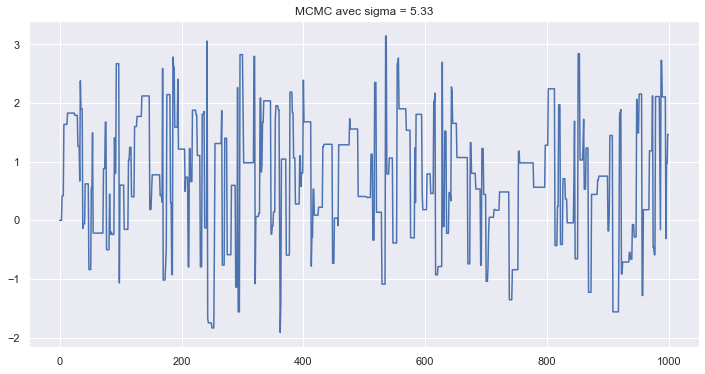

In [209]:
plt.figure(figsize=(12,6))
plt.plot(p)
plt.title('MCMC avec sigma = 5.33')

### Metropolis poiur $\kappa$

In [ ]:
df = pd.DataFrame()
rate, sigma = [],[]
for j in np.linspace(5,6,10):
    p = np.empty(1000)
    r = np.empty(1000)
    p[0]=data['prob'][0]
    mu = rd.random()
    kappa = gen_exp(0.1)
    for n in range(1,1000):
        p[n], r[n] =metropolis_kappa(p[n-1], sig=j)
    rate.append(np.mean(r)),sigma.append(j)
df['sigma**2']= sigma
df['rate']= rate

## Gibbs sampling

On suppose qu'on dispose d'une chaîne de Markov (simulée ci-précédemment) et des distributions conditionnelles. 



In [210]:
n_sample = 1000
mu_0 = rd.random()
kappa_0 = gen_exp(0.1)
    
def gibbs_sampling(n,r, n_sample, kappa_0, mu_0):
    """ 
    Gibbs sampler 
            Input : 
                n : liste des nombres de personnes testées
                r : liste des nombres de personnes positives
                n_sample : la taille de l'échantillonnage voulu
                & autres paramètres d'initialisation.
            Output : 
            
    """
    p = np.empty(n_sample)
    samples = np.empty([n_sample+1, 3])  #sampled points
    samples[0] = [mu_0, kappa_0, p]

    for i in range(n_sample):

        # Sample from p(x_0|x_1)
        p = [gen_cond_p(n[j], kappa_0, r[j], mu_0) for j in range(len(n))]

        # Sample from p(x_1|x_0)
        mu_0 = [metropolis_mu(x, sig, mu, kappa)]
          
        kappa_0 = 
        
        samples[i+1] = [p_0, mu_0, kappa_0]

    return samples

SyntaxError: invalid syntax (<ipython-input-210-c6c4703cdbae>, line 25)